In [ ]:

import tqdm
import torch
import torch.nn as nn
import torch.functional as F
import numpy as np
import torch.nn.functional as F

In [ ]:
class Feed_forward(nn.Module):
  def __init__(self,n_embed):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(n_embed,4*n_embed),
        nn.ReLU(),
        nn.Linear(4*n_embed,n_embed))
  def forward(self,x):
    return self.net(x)

class MHA(nn.Module):
  def __init__(self,heads,d_embed):
    super().__init__()
    self.heads = heads
    self.d_embed = d_embed
    self.d_k = d_embed // heads
    self.Wq = nn.Linear(d_embed,d_embed)
    self.Wk = nn.Linear(d_embed,d_embed)
    self.Wv = nn.Linear(d_embed,d_embed)
    self.Wa = nn.Linear(d_embed,d_embed)
  def forward(self,Q,K,V):
    batch_size = Q.size(0)
    Q = self.Wq(Q).view(batch_size, -1, self.heads, self.d_k).transpose(1, 2)
    K = self.Wk(K).view(batch_size, -1, self.heads, self.d_k).transpose(1, 2)
    V = self.Wv(V).view(batch_size, -1, self.heads, self.d_k).transpose(1, 2)

    scor = torch.matmul(Q,K.transpose(-2,-1)/torch.sqrt(torch.tensor(self.d_k, dtype=torch.float32)))
    A = F.softmax(scor,dim = -1)
    output = torch.matmul(A,V)
    output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_embed)
    return self.Wa(output)


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=2048):
        super().__init__()
        self.d_model = d_model
        self.max_len = max_len

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)  # [1, max_len, d_model]
        self.register_buffer("pe", pe)

    def forward(self, x):
        """
        x: (B, T, D)
        returns: positional encoding (1, T, D)
        """
        return self.pe[:, :x.size(1), :].to(x.device)


class Encoder(nn.Module):
  def __init__(self,vocab_size):
    super().__init__()
    self.pos = PositionalEncoding(100)
    self.mha = MHA(4,100)
    self.norm = nn.LayerNorm(100)
    self.ff = Feed_forward(100)
    self.token_embedding = nn.Embedding(vocab_size, 100)
  def forward(self,x):
    x = self.token_embedding(x)
    x1 = self.pos(x)
    x2 = self.mha(x,x,x)
    x3 = x1 + x2
    x4 = self.norm(x3)
    x5 = self.ff(x4)
    x6 = x5 + x4
    x7 = self.norm(x6)
    #print(x7.shape)
    return x7


class mask_MHA(nn.Module):
  def __init__(self,heads,d_embed):
    super().__init__()
    self.heads = heads
    self.d_embed = d_embed
    self.d_k = d_embed // heads
    self.Wq = nn.Linear(d_embed,d_embed)
    self.Wk = nn.Linear(d_embed,d_embed)
    self.Wv = nn.Linear(d_embed,d_embed)
    self.Wa = nn.Linear(d_embed,d_embed)
  def forward(self,Q,K,V):
    batch_size = Q.size(0)
    Q = self.Wq(Q).view(batch_size, -1, self.heads, self.d_k).transpose(1, 2)
    K = self.Wk(K).view(batch_size, -1, self.heads, self.d_k).transpose(1, 2)
    V = self.Wv(V).view(batch_size, -1, self.heads, self.d_k).transpose(1, 2)

    scor = torch.matmul(Q,K.transpose(-2,-1)/torch.sqrt(torch.tensor(self.d_k, dtype=torch.float32)))
    mask = torch.triu(torch.ones_like(scor), diagonal=1).bool()

    # Заменяем элементы выше диагонали на -inf
    scor.masked_fill_(mask, float('-inf'))
    A = F.softmax(scor,dim = -1)
    output = torch.matmul(A,V)
    output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_embed)
    return self.Wa(output)


class decoder(nn.Module):
  def __init__(self,vocab_size):
    super().__init__()
    self.mmha = mask_MHA(4,100)
    self.norm = nn.LayerNorm(100)
    self.mha2 = MHA(4,100)
    self.ff2 = Feed_forward(100)
    self.lin = nn.Linear(100, vocab_size)
    self.pos = PositionalEncoding(100)
    self.token_embedding = nn.Embedding(71, 100)
  def forward(self,x,y):
    x = self.token_embedding(x)
    x1 = self.pos(x)
    x2 = self.mmha(x1,x1,x1)
    x3 = x1 + x2
    x4 = self.norm(x3)
    #print(x4.shape)
    x5 = self.mha2(x4,y,y)
    x6 = x5 + x4
    x7 = self.norm(x6)
    x8 = self.ff2(x7)
    x9 = x8 + x7
    x10 = self.norm(x9)
    x11 = self.lin(x10)
    x12 = F.softmax(x11,dim=-1)
    return x12


class Transformer(nn.Module):
  def __init__(self,vocab_size):
    super().__init__()
    self.enc = Encoder(vocab_size)
    self.dec = decoder(vocab_size)
    self.vocab_size = vocab_size
  def forward(self,x):
    enc = self.enc(x)
    dec = self.dec(x,enc)
    return dec
  @torch.no_grad()
  def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            logits = self.forward(idx)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            idx = torch.cat([idx, next_token], dim=1)
        return idx


model = Transformer(71)


In [ ]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

class PositionalEncoding(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.d_model = d_model

    def forward(self, x):
        # Упрощенная позиционная кодировка
        seq_len = x.size(1)
        position = torch.arange(seq_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, self.d_model, 2).float() * (-np.log(10000.0) / self.d_model))
        pe = torch.zeros(1, seq_len, self.d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        return x + pe.to(x.device)

class MHA(nn.Module):
    def __init__(self, num_heads, d_model):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads

        self.W_Q = nn.Linear(d_model, d_model)
        self.W_K = nn.Linear(d_model, d_model)
        self.W_V = nn.Linear(d_model, d_model)
        self.W_O = nn.Linear(d_model, d_model)

    def forward(self, Q, K, V):
        B = Q.size(0)

        Q = self.W_Q(Q).view(B, -1, self.num_heads, self.head_dim).transpose(1, 2)
        K = self.W_K(K).view(B, -1, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.W_V(V).view(B, -1, self.num_heads, self.head_dim).transpose(1, 2)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32))
        weights = F.softmax(scores, dim=-1)
        output = torch.matmul(weights, V)

        output = output.transpose(1, 2).contiguous().view(B, -1, self.d_model)
        return self.W_O(output)

class mask_MHA(MHA):
    def forward(self, Q, K, V):
        B, seq_len, _ = Q.size()

        # Создаем маску для последующих токенов
        mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool().to(Q.device)

        Q = self.W_Q(Q).view(B, -1, self.num_heads, self.head_dim).transpose(1, 2)
        K = self.W_K(K).view(B, -1, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.W_V(V).view(B, -1, self.num_heads, self.head_dim).transpose(1, 2)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32))
        scores = scores.masked_fill(mask, float('-inf'))
        weights = F.softmax(scores, dim=-1)
        output = torch.matmul(weights, V)

        output = output.transpose(1, 2).contiguous().view(B, -1, self.d_model)
        return self.W_O(output)

class Feed_forward(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.linear1 = nn.Linear(d_model, 4*d_model)
        self.linear2 = nn.Linear(4*d_model, d_model)

    def forward(self, x):
        return self.linear2(F.relu(self.linear1(x)))

class Encoder(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.pos = PositionalEncoding(100)
        self.mha = MHA(4, 100)
        self.norm = nn.LayerNorm(100)
        self.ff = Feed_forward(100)
        self.token_embedding = nn.Embedding(vocab_size, 100)

    def forward(self, x):
        x = self.token_embedding(x)
        x1 = self.pos(x)
        x2 = self.mha(x1, x1, x1)
        x3 = x1 + x2
        x4 = self.norm(x3)
        x5 = self.ff(x4)
        x6 = x5 + x4
        x7 = self.norm(x6)
        return x7

class Decoder(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.mmha = mask_MHA(4, 100)
        self.norm = nn.LayerNorm(100)
        self.mha2 = MHA(4, 100)
        self.ff2 = Feed_forward(100)
        self.lin = nn.Linear(100, vocab_size)
        self.pos = PositionalEncoding(100)
        self.token_embedding = nn.Embedding(vocab_size, 100)

    def forward(self, x, y):
        x = self.token_embedding(x)
        x1 = self.pos(x)
        x2 = self.mmha(x1, x1, x1)
        x3 = x1 + x2
        x4 = self.norm(x3)
        x5 = self.mha2(x4, y, y)
        x6 = x5 + x4
        x7 = self.norm(x6)
        x8 = self.ff2(x7)
        x9 = x8 + x7
        x10 = self.norm(x9)
        x11 = self.lin(x10)
        x12 = F.log_softmax(x11, dim=-1)
        return x12

class Transformer(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.enc = Encoder(vocab_size)
        self.dec = Decoder(vocab_size)
        self.vocab_size = vocab_size

    def forward(self, x, y=None):
        enc = self.enc(x)
        dec = self.dec(x if y is None else y, enc)
        return dec

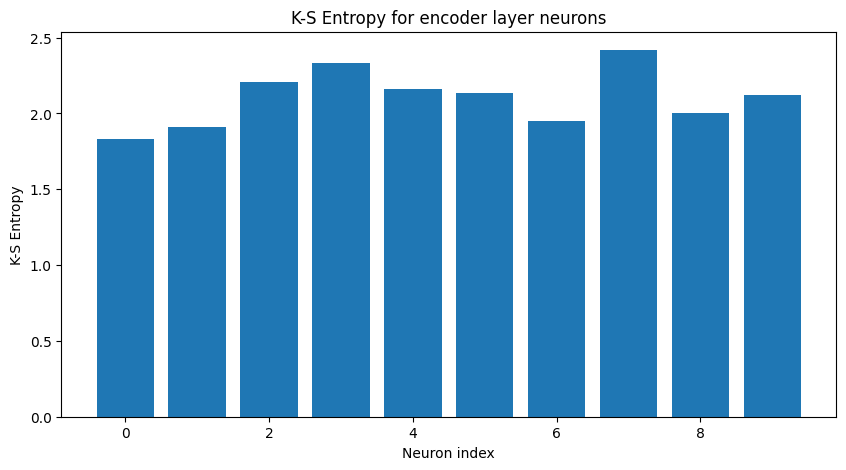

Средняя K-S энтропия для encoder: 2.1081


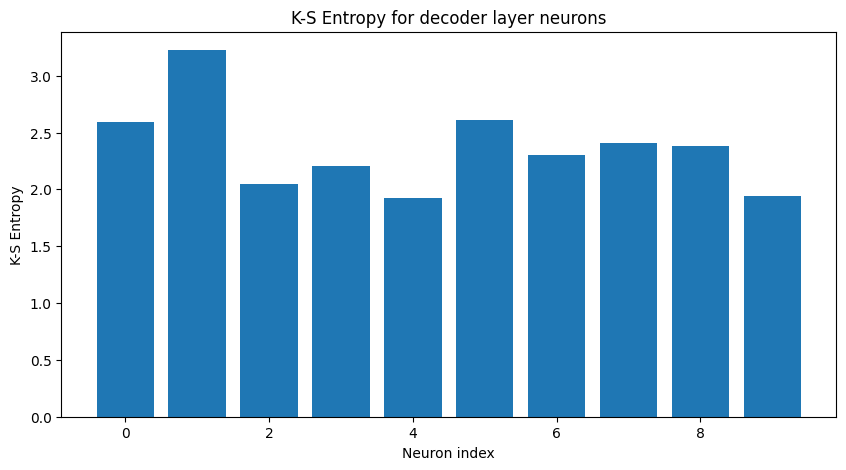

Средняя K-S энтропия для decoder: 2.3641


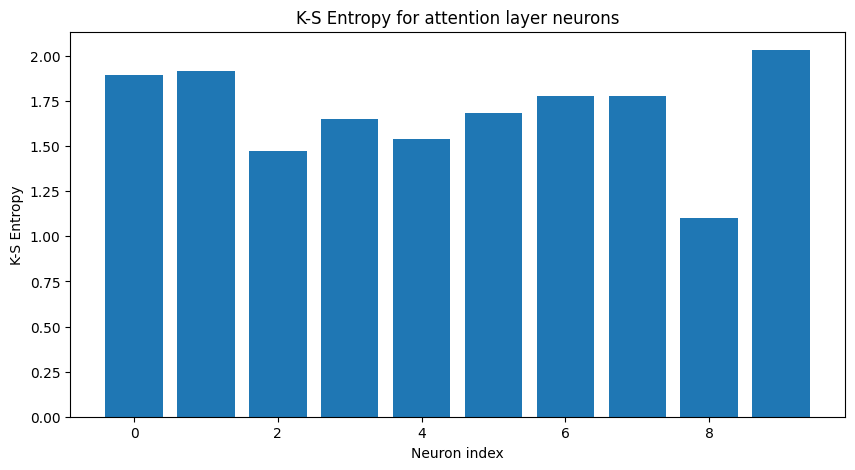

Средняя K-S энтропия для attention: 1.6852


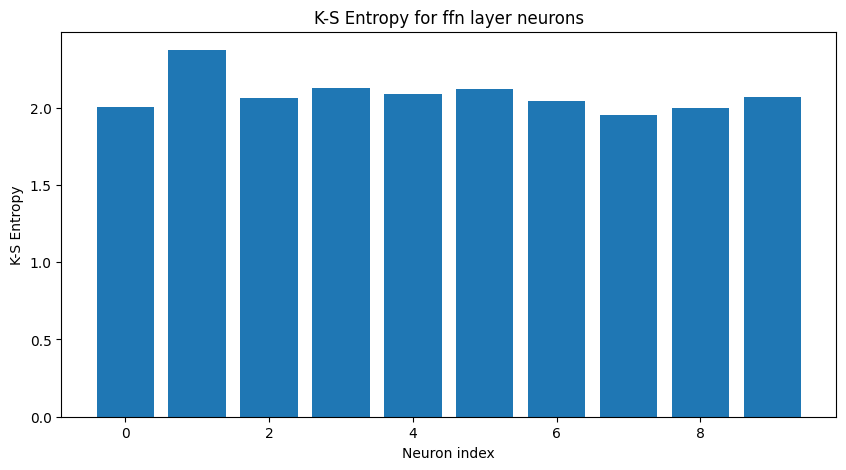

Средняя K-S энтропия для ffn: 2.0846


In [ ]:


def calculate_ks_entropy(activations, m=3, tau=5, r_factor=0.2):
    """Расчет K-S энтропии для активаций нейронов"""
    # Проверка и преобразование входных данных
    if isinstance(activations, (float, np.float32, np.float64)):
        return 0.0  # Не можем рассчитать энтропию для скалярного значения

    activations = np.asarray(activations)
    if activations.ndim > 1:
        activations = activations.flatten()

    if len(activations) < 10:  # Минимальное количество точек для анализа
        return 0.0

    # Нормализация данных (с защитой от деления на 0)
    std = np.std(activations)
    if std < 1e-12:
        return 0.0
    data = (activations - np.mean(activations)) / std

    # Параметры для анализа
    r = r_factor * np.std(data)

    # Реконструкция фазового пространства
    N = len(data)
    if N <= (m-1)*tau:
        return 0.0

    emb = np.array([data[i:i+(m-1)*tau+1:tau] for i in range(N-(m-1)*tau)])

    if len(emb) < 2:
        return 0.0

    # Расчет корреляционного интеграла
    try:
        dist = squareform(pdist(emb, 'chebyshev'))
        C = (np.sum(dist < r) - len(emb)) / (len(emb)*(len(emb)-1))
        return np.log(C) if C > 0 else 0.0
    except:
        return 0.0

def analyze_transformer_entropy(model, dataloader, layer_type='encoder', num_neurons=10):
    """Анализ энтропии для указанного типа слоев трансформера"""
    activations = []

    # Хук для сбора активаций
    def hook_fn(module, input, output):
        # Для внимания берем средние значения по головам
        if isinstance(module, (MHA, mask_MHA)):
            output = output.mean(dim=1)  # Усредняем по головам внимания

        # Преобразуем выход в numpy и сохраняем
        output = output.detach().cpu().numpy()
        if output.ndim > 1:
            # Для многомерных выходов сохраняем все нейроны
            output = output.reshape(output.shape[0], -1)  # [batch_size, features]
            activations.append(output)
        else:
            # Для одномерных выходов добавляем новое измерение
            activations.append(output.reshape(-1, 1))

    # Регистрация хуков
    hooks = []
    for name, module in model.named_modules():
        if layer_type == 'encoder' and isinstance(module, Encoder):
            hooks.append(module.register_forward_hook(hook_fn))
        elif layer_type == 'decoder' and isinstance(module, Decoder):
            hooks.append(module.register_forward_hook(hook_fn))
        elif layer_type == 'attention' and isinstance(module, (MHA, mask_MHA)):
            hooks.append(module.register_forward_hook(hook_fn))
        elif layer_type == 'ffn' and isinstance(module, Feed_forward):
            hooks.append(module.register_forward_hook(hook_fn))

    # Проход данных через модель
    with torch.no_grad():
        for batch in dataloader:
            if isinstance(batch, (list, tuple)):
                x = batch[0]
            else:
                x = batch
            model(x)
            if len(activations) > 20:  # Ограничим количество батчей
                break

    # Удаление хуков
    for hook in hooks:
        hook.remove()

    if not activations:
        return 0.0

    # Объединяем активации из всех батчей
    activations = np.concatenate(activations, axis=0)  # [total_samples, features]

    # Выбираем случайные нейроны для анализа
    if activations.ndim == 1:
        activations = activations.reshape(-1, 1)

    num_features = activations.shape[1]
    num_neurons = min(num_neurons, num_features)
    neuron_indices = np.random.choice(num_features, num_neurons, replace=False)

    # Расчет энтропии для выбранных нейронов
    entropies = []
    for idx in neuron_indices:
        neuron_data = activations[:, idx]
        E1 = calculate_ks_entropy(neuron_data, m=3, tau=5)
        E2 = calculate_ks_entropy(neuron_data, m=4, tau=5)
        ks_entropy = max(0, E1 - E2)
        entropies.append(ks_entropy)

    # Визуализация
    plt.figure(figsize=(10, 5))
    plt.bar(range(num_neurons), entropies)
    plt.title(f'K-S Entropy for {layer_type} layer neurons')
    plt.xlabel('Neuron index')
    plt.ylabel('K-S Entropy')
    plt.show()

    return np.mean(entropies) if entropies else 0.0


# Пример использования
if __name__ == "__main__":
    # Создаем модель и тестовый DataLoader
    vocab_size = 10000
    model = Transformer(vocab_size)

    # Создаем тестовые данные (замените на реальный DataLoader)
    test_data = [torch.randint(0, vocab_size, (32, 20)) for _ in range(10)]
    test_loader = test_data

    # Анализируем разные части трансформера
    for layer_type in ['encoder', 'decoder', 'attention', 'ffn']:
        mean_entropy = analyze_transformer_entropy(model, test_loader, layer_type=layer_type)
        print(f"Средняя K-S энтропия для {layer_type}: {mean_entropy:.4f}")

Analyzing initialization scale...


Analyzing bifurcations: 100%|██████████| 15/15 [00:00<00:00, 70.63it/s]


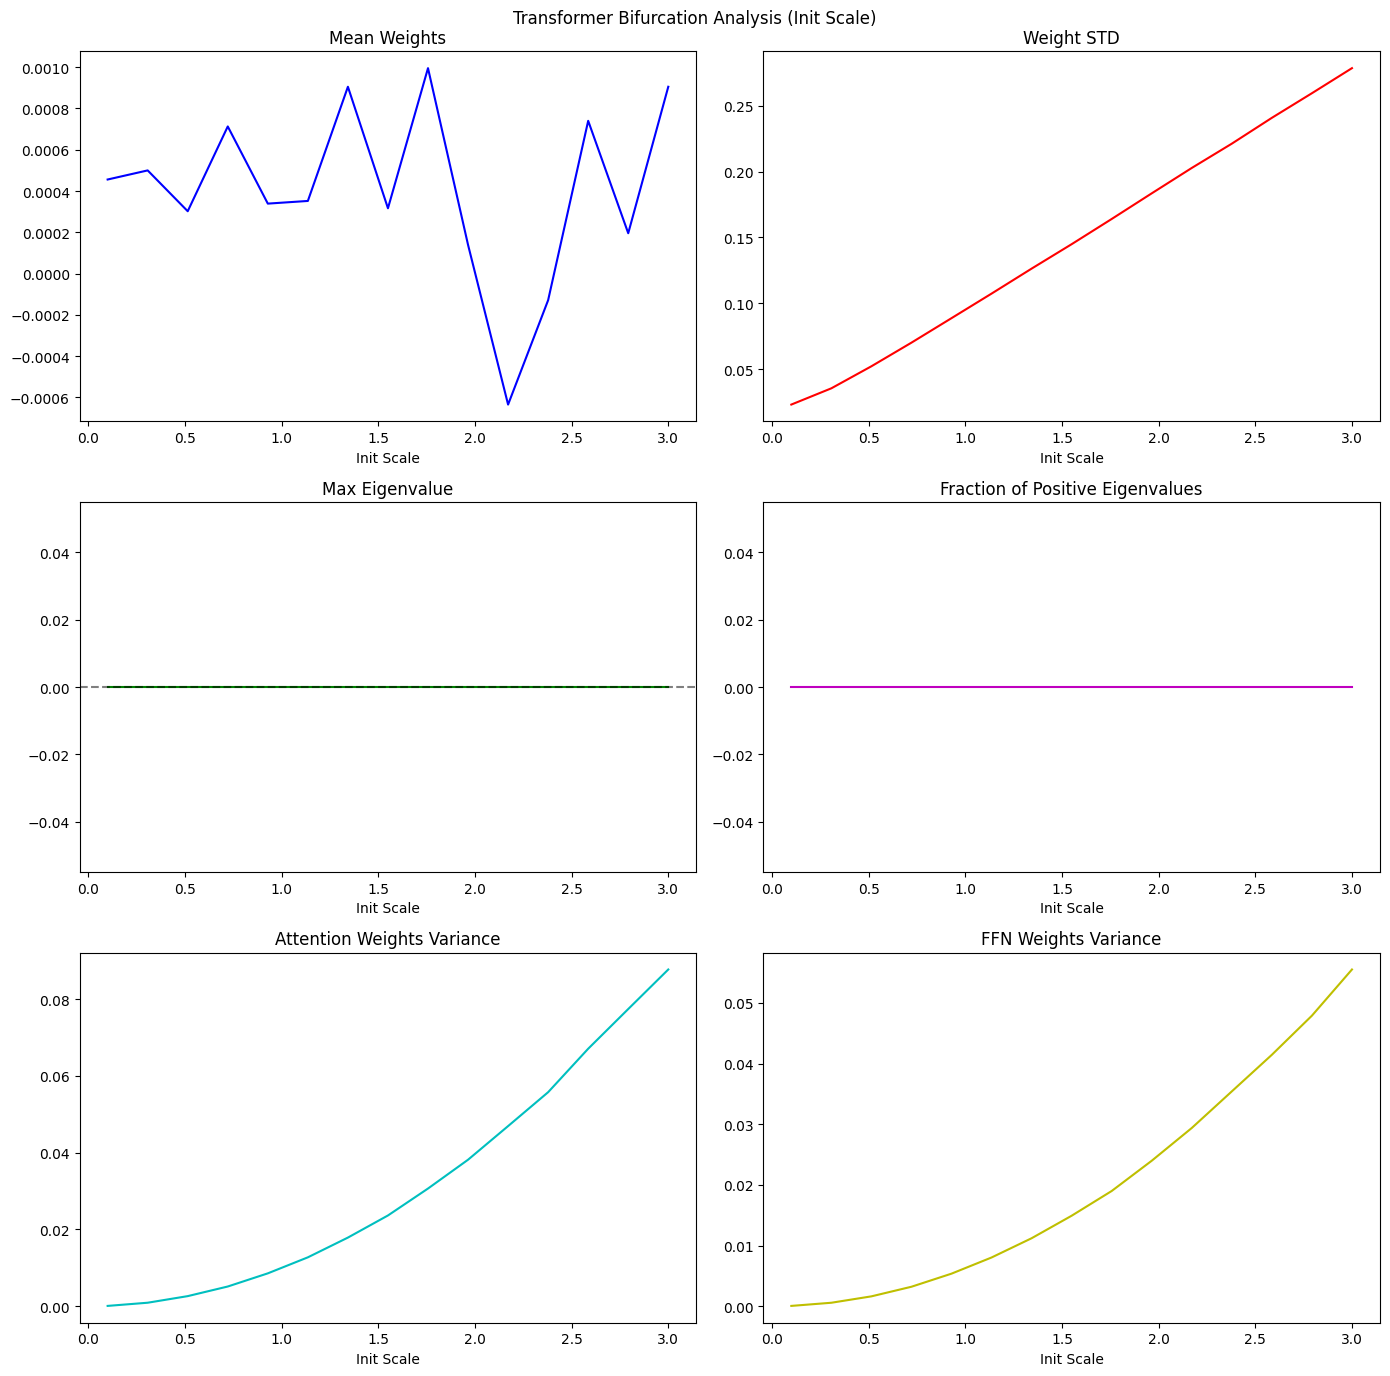

Analyzing attention temperature...


Analyzing bifurcations: 100%|██████████| 15/15 [00:00<00:00, 69.20it/s]


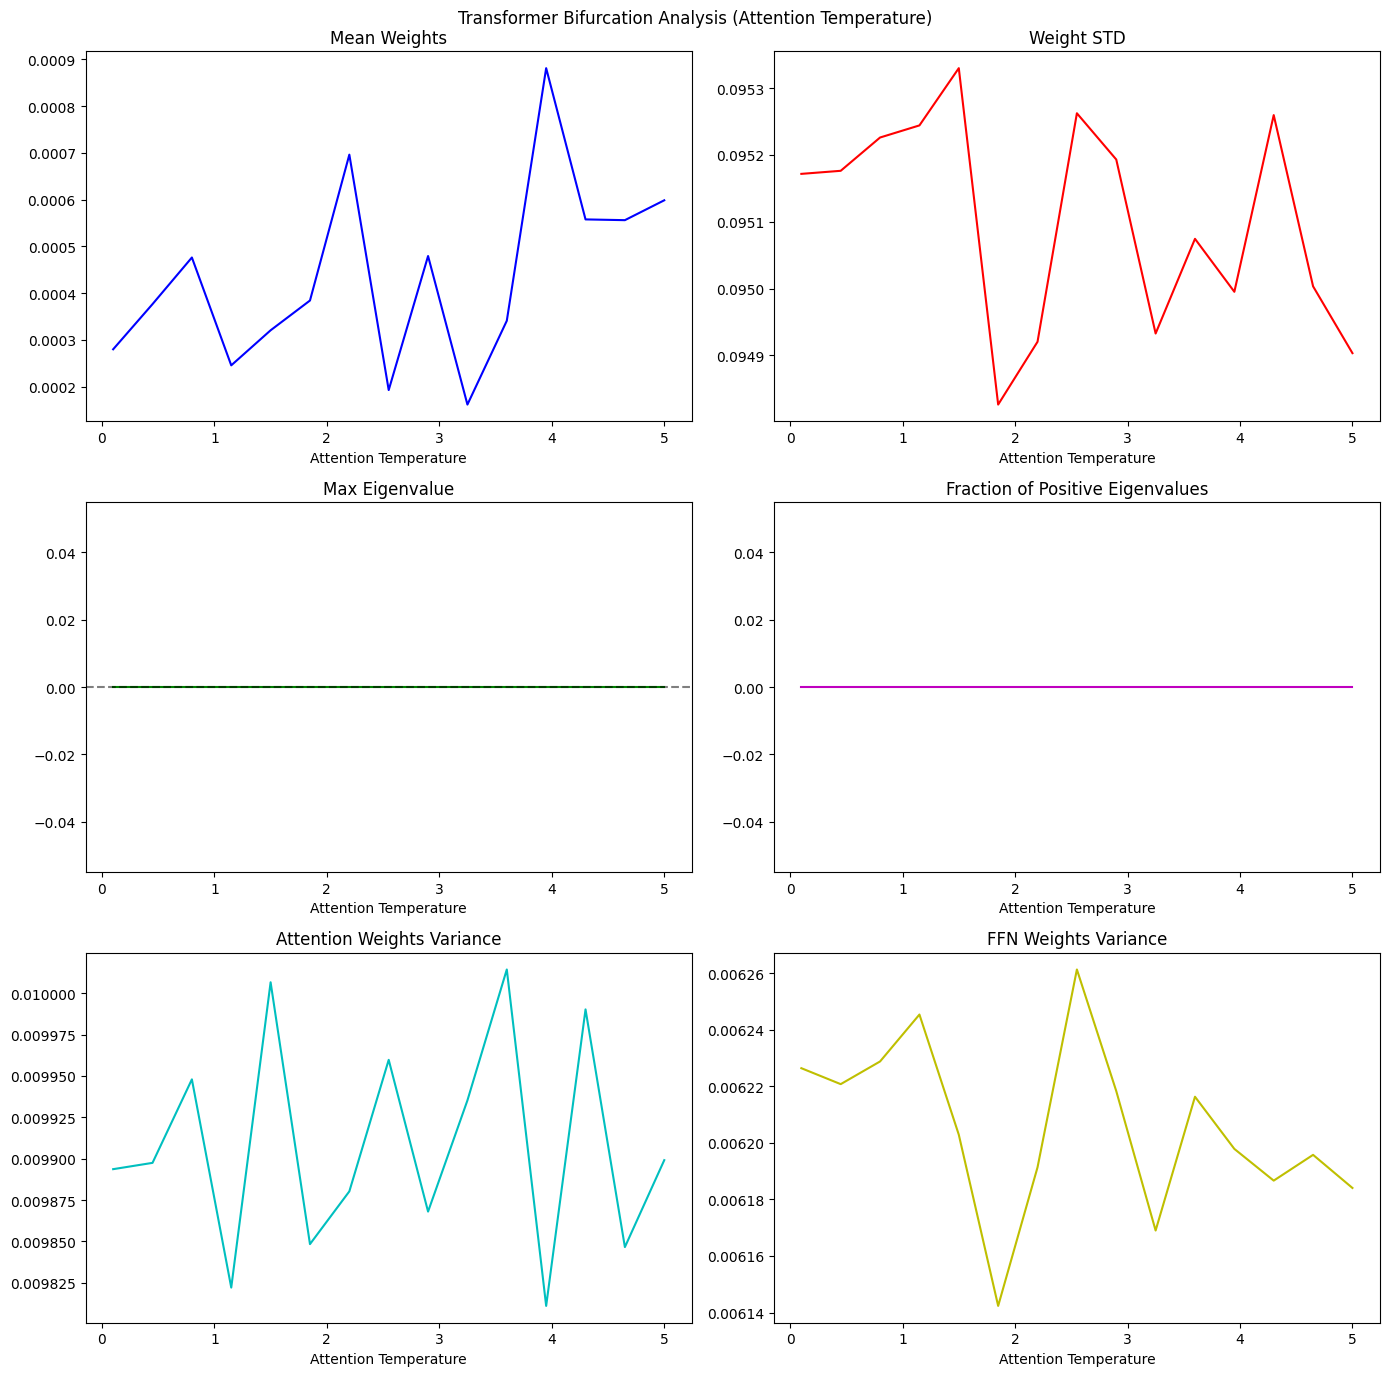

Analyzing FFN gain...


Analyzing bifurcations: 100%|██████████| 15/15 [00:00<00:00, 60.19it/s]


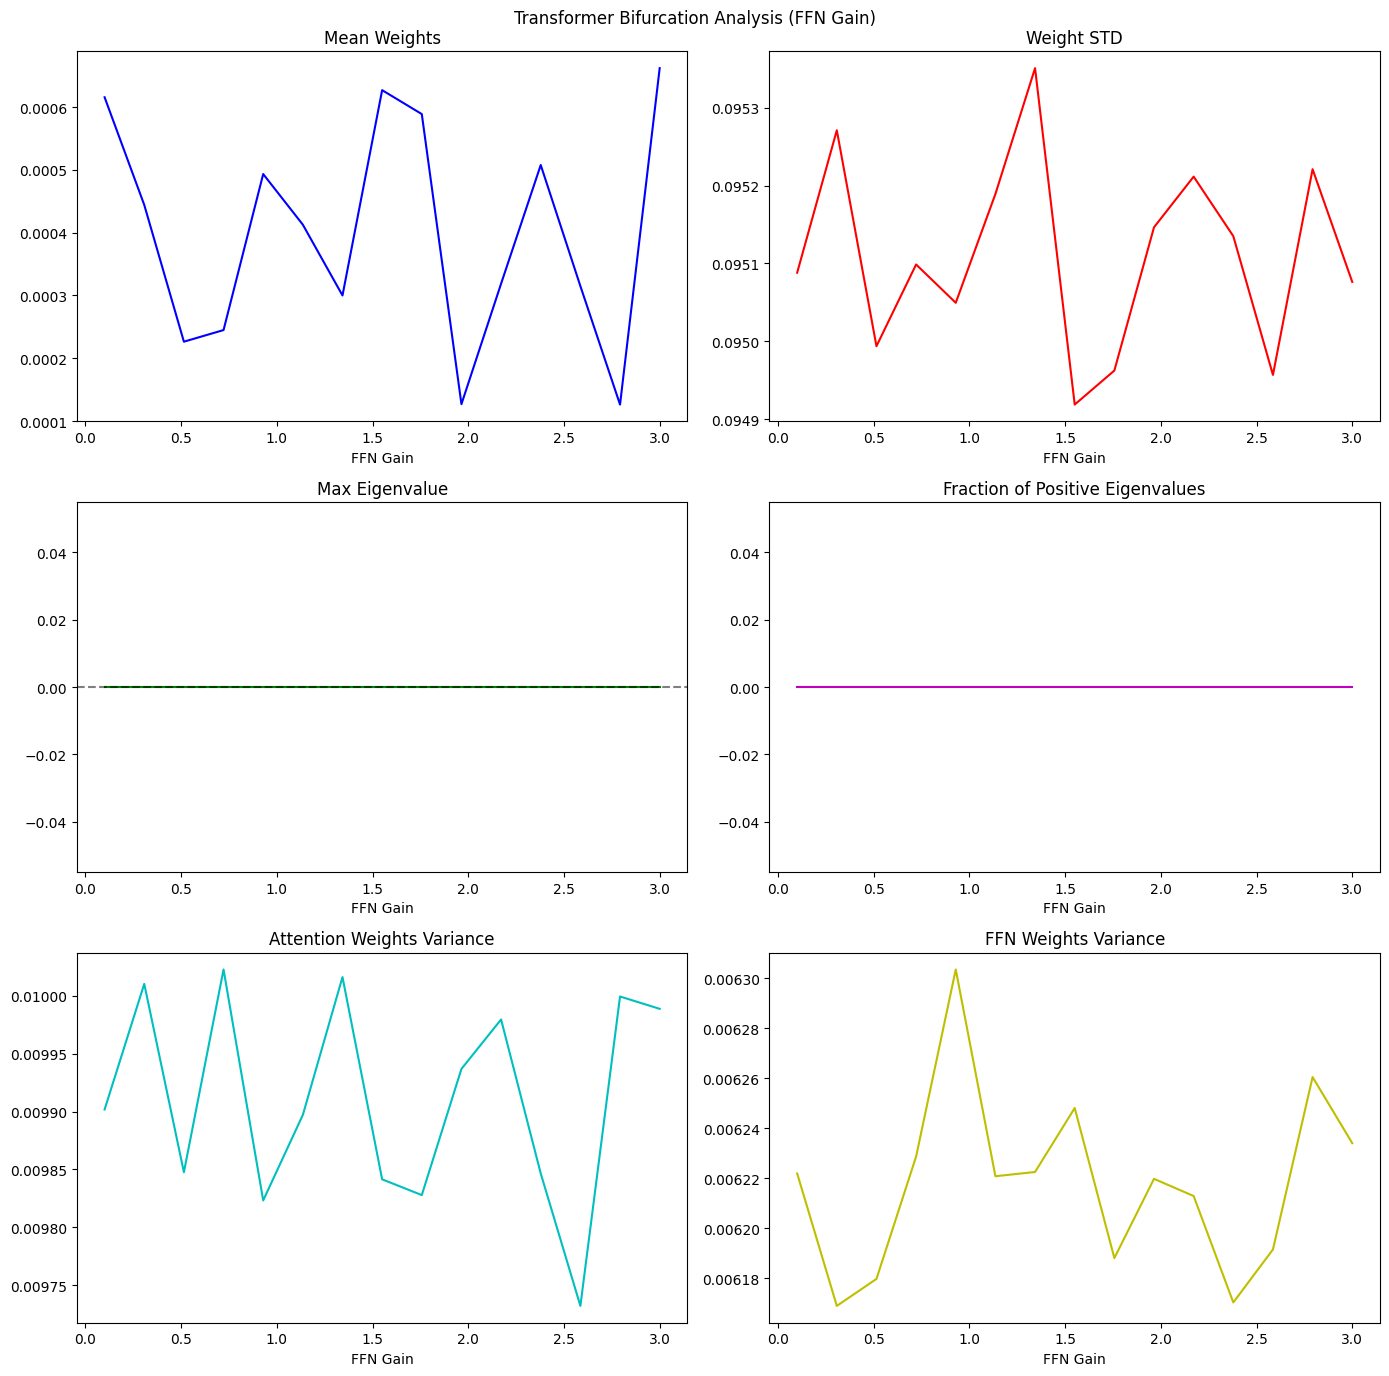

In [ ]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.linalg import eigvals
from tqdm import tqdm

class TransformerBifurcationAnalyzer:
    def __init__(self, model_class, device='cuda'):
        self.model_class = model_class
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')

    def generate_bifurcation_data(self, param_name, param_range, vocab_size=1000, seq_len=10, n_samples=5):
        """Генерация данных о бифуркациях для Transformer"""
        results = []

        for param_value in tqdm(param_range, desc='Analyzing bifurcations'):
            model = self.model_class(vocab_size=vocab_size, **{param_name: param_value}).to(self.device)
            dynamics = self._analyze_transformer_dynamics(model, seq_len, n_samples)
            results.append((param_value, dynamics))

        return results

    def _analyze_transformer_dynamics(self, model, seq_len, n_samples):
        """Анализ динамики Transformer через веса модели и собственные значения"""
        model.eval()
        dynamics = {
            'mean_weight': 0,
            'weight_std': 0,
            'max_eigenvalue': 0,
            'positive_eigs': 0,
            'attention_var': 0,
            'ffn_var': 0
        }

        # Собираем все веса модели
        weights = []
        attention_weights = []
        ffn_weights = []

        for name, param in model.named_parameters():
            if param.requires_grad:
                weights.append(param.detach().cpu().numpy().flatten())
                if 'mha' in name or 'attention' in name:
                    attention_weights.append(param.detach().cpu().numpy().flatten())
                elif 'ff' in name or 'feed_forward' in name:
                    ffn_weights.append(param.detach().cpu().numpy().flatten())

        if len(weights) == 0:
            return dynamics

        weights = np.concatenate(weights)

        # Вычисляем статистики весов
        dynamics['mean_weight'] = np.mean(weights)
        dynamics['weight_std'] = np.std(weights)

        # Статистики для attention и FFN
        if attention_weights:
            attention_weights = np.concatenate(attention_weights)
            dynamics['attention_var'] = np.var(attention_weights)

        if ffn_weights:
            ffn_weights = np.concatenate(ffn_weights)
            dynamics['ffn_var'] = np.var(ffn_weights)

        # Для матрицы Якобиана используем ковариационную матрицу весов
        if len(weights) > 1000:  # Ограничим размер для скорости
            weights = np.random.choice(weights, 1000, replace=False)

        cov_matrix = np.cov(weights.reshape(-1, 1), rowvar=False)
        try:
            eigenvalues = eigvals(cov_matrix)
            real_parts = np.real(eigenvalues)
            dynamics['max_eigenvalue'] = np.max(real_parts)
            dynamics['positive_eigs'] = np.sum(real_parts > 0) / len(real_parts)
        except:
            pass

        return dynamics

    def plot_bifurcation_diagram(self, results, param_name):
        """Визуализация результатов для Transformer"""
        params = [r[0] for r in results]
        metrics = [r[1] for r in results]

        fig, axs = plt.subplots(3, 2, figsize=(14, 14))

        # 1. Среднее значение весов
        axs[0,0].plot(params, [m['mean_weight'] for m in metrics], 'b-')
        axs[0,0].set_title('Mean Weights')
        axs[0,0].set_xlabel(param_name)

        # 2. Стандартное отклонение весов
        axs[0,1].plot(params, [m['weight_std'] for m in metrics], 'r-')
        axs[0,1].set_title('Weight STD')
        axs[0,1].set_xlabel(param_name)

        # 3. Максимальное собственное значение
        axs[1,0].plot(params, [m['max_eigenvalue'] for m in metrics], 'g-')
        axs[1,0].axhline(0, color='k', linestyle='--', alpha=0.5)
        axs[1,0].set_title('Max Eigenvalue')
        axs[1,0].set_xlabel(param_name)

        # 4. Доля положительных собственных значений
        axs[1,1].plot(params, [m['positive_eigs'] for m in metrics], 'm-')
        axs[1,1].set_title('Fraction of Positive Eigenvalues')
        axs[1,1].set_xlabel(param_name)

        # 5. Дисперсия весов attention
        axs[2,0].plot(params, [m['attention_var'] for m in metrics], 'c-')
        axs[2,0].set_title('Attention Weights Variance')
        axs[2,0].set_xlabel(param_name)

        # 6. Дисперсия весов FFN
        axs[2,1].plot(params, [m['ffn_var'] for m in metrics], 'y-')
        axs[2,1].set_title('FFN Weights Variance')
        axs[2,1].set_xlabel(param_name)

        plt.suptitle(f'Transformer Bifurcation Analysis ({param_name})')
        plt.tight_layout()
        plt.show()

# Модифицированный Transformer с параметрами для анализа
class ParametrizedTransformer(nn.Module):
    def __init__(self, vocab_size, init_scale=1.0, attention_temp=1.0, ffn_gain=1.0):
        super().__init__()
        self.init_scale = init_scale
        self.attention_temp = attention_temp  # "Температура" для softmax в attention
        self.ffn_gain = ffn_gain  # Коэффициент усиления FFN

        self.pos = PositionalEncoding(100)
        self.mha = MHA(4, 100)
        self.norm = nn.LayerNorm(100)
        self.ff = Feed_forward(100)
        self.token_embedding = nn.Embedding(vocab_size, 100)

        # Инициализация с заданным масштабом
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=self.init_scale/np.sqrt(m.weight.shape[1]))
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Embedding):
                nn.init.normal_(m.weight, mean=0, std=self.init_scale/np.sqrt(m.weight.shape[1]))

    def forward(self, x):
        # Модифицированный forward с параметрами
        x = self.token_embedding(x)
        x1 = self.pos(x)

        # Применяем temperature к attention
        original_softmax = torch.nn.functional.softmax
        def tempered_softmax(x, dim=None, _stacklevel=3):
            return original_softmax(x/self.attention_temp, dim=dim, _stacklevel=_stacklevel)

        torch.nn.functional.softmax = tempered_softmax
        try:
            x2 = self.mha(x1, x1, x1)
        finally:
            torch.nn.functional.softmax = original_softmax

        x3 = x1 + x2
        x4 = self.norm(x3)
        x5 = self.ff(x4) * self.ffn_gain  # Применяем коэффициент усиления
        x6 = x5 + x4
        x7 = self.norm(x6)
        return x7

if __name__ == "__main__":
    # Анализ бифуркаций для Transformer

    # 1. Анализ масштаба инициализации
    print("Analyzing initialization scale...")
    analyzer = TransformerBifurcationAnalyzer(ParametrizedTransformer)
    init_scales = np.linspace(0.1, 3.0, 15)
    results = analyzer.generate_bifurcation_data('init_scale', init_scales)
    analyzer.plot_bifurcation_diagram(results, 'Init Scale')

    # 2. Анализ температуры attention
    print("Analyzing attention temperature...")
    attention_temps = np.linspace(0.1, 5.0, 15)
    results = analyzer.generate_bifurcation_data('attention_temp', attention_temps)
    analyzer.plot_bifurcation_diagram(results, 'Attention Temperature')

    # 3. Анализ коэффициента усиления FFN
    print("Analyzing FFN gain...")
    ffn_gains = np.linspace(0.1, 3.0, 15)
    results = analyzer.generate_bifurcation_data('ffn_gain', ffn_gains)
    analyzer.plot_bifurcation_diagram(results, 'FFN Gain')

In [ ]:
import torch
import numpy as np
from scipy.linalg import eigvals
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

class TransformerSingularPerturbationAnalyzer:
    def __init__(self, model, eps=1e-3, device='cpu'):
        self.model = model.to(device)
        self.eps = eps
        self.device = device

    def compute_jacobian(self, x):
        """Вычисление матрицы Якобиана для Transformer с учетом его архитектуры"""
        x = x.clone().detach().requires_grad_(True).to(self.device)
        self.model.zero_grad()

        # Получаем выходы модели (для Transformer берем выход декодера)
        y = self.model(x)

        # Для классификации берем последний слой
        if isinstance(y, tuple):
            y = y[0]  # если модель возвращает кортеж

        output_dim = y.shape[-1]
        input_dim = x.numel()

        # Для квадратной матрицы берем min(input_dim, output_dim)
        dim = min(input_dim, output_dim)
        jacobian = torch.zeros(dim, dim, device=self.device)

        for i in range(dim):
            grad_output = torch.zeros_like(y)
            grad_output[..., i] = 1.0  # для многомерного выхода
            y.backward(grad_output, retain_graph=True)

            # Берем только первые dim элементов градиента
            jacobian[i] = x.grad.flatten()[:dim]
            x.grad.zero_()

        return jacobian.cpu().numpy()

    def analyze_time_scales(self, dataloader, n_samples=5):
        """Анализ временных масштабов для Transformer"""
        time_scales = []

        for i, (inputs, _) in enumerate(dataloader):
            if i >= n_samples:
                break

            # Для Transformer вход обычно имеет размер (batch, seq_len)
            if inputs.dim() == 4:  # если изображения
                inputs = inputs.flatten(start_dim=1)
            inputs = inputs.to(self.device)

            try:
                J = self.compute_jacobian(inputs)
                if J.shape[0] != J.shape[1]:
                    print(f"Предупреждение: матрица {J.shape} не квадратная, пропускаем")
                    continue

                eigenvalues = eigvals(J)

                # Разделение на быстрые и медленные моды
                fast = [ev for ev in eigenvalues if abs(ev) > 1/self.eps]
                slow = [ev for ev in eigenvalues if abs(ev) <= 1/self.eps]

                time_scales.append({
                    'fast': fast,
                    'slow': slow,
                    'ratio': len(fast) / max(1, len(slow))
                })

            except Exception as e:
                print(f"Ошибка при анализе образца {i}: {str(e)}")
                continue

        return time_scales

    def visualize_results(self, time_scales):
        """Визуализация результатов для Transformer"""
        if not time_scales:
            print("Нет данных для визуализации")
            return

        plt.figure(figsize=(12, 5))

        # Распределение соотношений мод
        plt.subplot(121)
        ratios = [ts['ratio'] for ts in time_scales if 'ratio' in ts]
        if ratios:
            plt.hist(ratios, bins=20, alpha=0.7)
            plt.xlabel('Соотношение быстрых/медленных мод')
            plt.ylabel('Частота')
            plt.title('Распределение временных масштабов')
        else:
            plt.text(0.5, 0.5, 'Нет данных', ha='center')

        # Собственные значения в комплексной плоскости
        plt.subplot(122)
        has_data = False
        for ts in time_scales:
            if 'fast' in ts and ts['fast']:
                fast = np.array(ts['fast'])
                plt.scatter(fast.real, fast.imag, c='r', alpha=0.5, label='Быстрые')
                has_data = True
            if 'slow' in ts and ts['slow']:
                slow = np.array(ts['slow'])
                plt.scatter(slow.real, slow.imag, c='b', alpha=0.5, label='Медленные')
                has_data = True

        if has_data:
            plt.axvline(x=-1/self.eps, linestyle='--', color='gray')
            plt.xlabel('Re(λ)')
            plt.ylabel('Im(λ)')
            plt.legend()
            plt.title('Собственные значения')
        else:
            plt.text(0.5, 0.5, 'Нет данных', ha='center')

        plt.tight_layout()
        plt.show()

# Пример использования с Transformer моделью
if __name__ == "__main__":
    # 1. Настройка устройства
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # 2. Создаем тестовую Transformer модель (упрощенную)
    vocab_size = 10000  # примерный размер словаря
    model = Transformer(vocab_size).to(device)

    # 3. Создаем тестовый DataLoader (имитируем текстовые данные)
    # Для реального использования нужно заменить на свои данные
    class DummyDataset(torch.utils.data.Dataset):
        def __init__(self, num_samples=100, seq_len=32):
            self.data = torch.randint(0, vocab_size, (num_samples, seq_len))

        def __len__(self):
            return len(self.data)

        def __getitem__(self, idx):
            return self.data[idx], 0  # возвращаем фиктивные метки

    train_dataset = DummyDataset(num_samples=100, seq_len=32)
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

    # 4. Анализ сингулярных возмущений
    analyzer = TransformerSingularPerturbationAnalyzer(model, eps=1e-2, device=device)
    time_scales = analyzer.analyze_time_scales(train_loader, n_samples=5)
    analyzer.visualize_results(time_scales)

    # 5. Статистика
    if time_scales:
        avg_ratio = np.mean([ts['ratio'] for ts in time_scales if 'ratio' in ts])
        print(f"Среднее соотношение быстрых/медленных мод: {avg_ratio:.2f}")
        print(f"Общее количество проанализированных образцов: {len(time_scales)}")
    else:
        print("Не удалось проанализировать ни одного образца")

Ошибка при анализе образца 0: only Tensors of floating point dtype can require gradients
Ошибка при анализе образца 1: only Tensors of floating point dtype can require gradients
Ошибка при анализе образца 2: only Tensors of floating point dtype can require gradients
Ошибка при анализе образца 3: only Tensors of floating point dtype can require gradients
Ошибка при анализе образца 4: only Tensors of floating point dtype can require gradients
Нет данных для визуализации
Не удалось проанализировать ни одного образца



Analyzing layer: enc.mha.W_Q
Lyapunov exponents (top 5): [3.4646254 3.4069946 3.365211  3.3381264 3.3206315]
Max Lyapunov: 3.4646

Analyzing layer: enc.mha.W_K
Lyapunov exponents (top 5): [3.4011672 3.396379  3.3728669 3.3129325 3.3116667]
Max Lyapunov: 3.4012

Analyzing layer: enc.mha.W_V
Lyapunov exponents (top 5): [3.4516435 3.4216166 3.417512  3.3418138 3.314522 ]
Max Lyapunov: 3.4516

Analyzing layer: enc.ff.linear1
Lyapunov exponents (top 5): [3.9660285 3.9388568 3.9155786 3.8623328 3.8602939]
Max Lyapunov: 3.9660

Analyzing layer: enc.ff.linear2
Lyapunov exponents (top 5): [2.423701  2.3138707 2.2188995 2.1548724 2.1422577]
Max Lyapunov: 2.4237

Analyzing layer: dec.mmha.W_Q
Lyapunov exponents (top 5): [3.4844327 3.37259   3.3503668 3.341517  3.340889 ]
Max Lyapunov: 3.4844

Analyzing layer: dec.mmha.W_K
Lyapunov exponents (top 5): [3.4296663 3.3948834 3.3785746 3.3561609 3.3257463]
Max Lyapunov: 3.4297

Analyzing layer: dec.mmha.W_V
Lyapunov exponents (top 5): [3.4896445 3.401

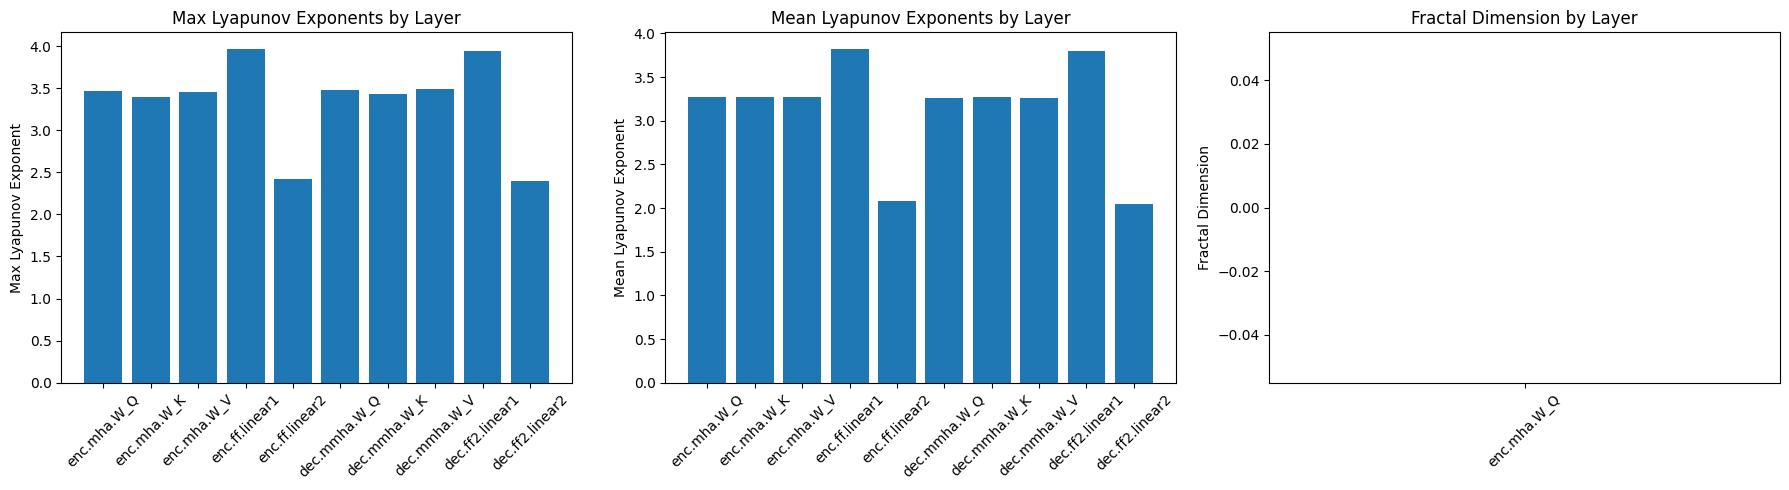

In [ ]:
import numpy as np
from scipy.linalg import eigvals, qr
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

class TransformerAnalyzer:
    def __init__(self, model, device='cpu'):
        self.model = model.to(device)
        self.device = device

    def get_layer_activations(self, layer_name, input_sequences, n_samples=100):
        """Получение активаций конкретного слоя"""
        activations = []

        def hook(module, input, output):
            activations.append(output.detach().cpu().numpy())

        layer = dict(self.model.named_modules())[layer_name]
        handle = layer.register_forward_hook(hook)

        with torch.no_grad():
            for i, seq in enumerate(input_sequences):
                if i >= n_samples:
                    break
                seq = seq.to(self.device).unsqueeze(0)
                _ = self.model(seq)

        handle.remove()
        return np.concatenate(activations) if activations else None

    def lyapunov_exponents(self, layer_name, input_sequences, n_samples=100):
        """Вычисление показателей Ляпунова для слоя Transformer"""
        activations = self.get_layer_activations(layer_name, input_sequences, n_samples)
        if activations is None or len(activations) == 0:
            return None

        # Приводим к 2D матрице (samples, features)
        if activations.ndim > 2:
            activations = activations.reshape(activations.shape[0], -1)

        # QR разложение для ортогонализации
        _, r = qr(activations.T, mode='economic')
        diag_r = np.diag(r)

        # Избегаем деления на ноль и логарифма от нуля
        diag_r = np.where(diag_r == 0, 1e-12, diag_r)
        lexp = np.log(np.abs(diag_r))

        return lexp

    def fractal_dimension(self, layer_name, input_sequences, k=5, n_samples=500):
        """Вычисление фрактальной размерности для слоя Transformer"""
        activations = self.get_layer_activations(layer_name, input_sequences, n_samples)
        if activations is None or len(activations) < 100:
            return None

        # Приводим к 2D матрице
        if activations.ndim > 2:
            activations = activations.reshape(activations.shape[0], -1)

        # Уменьшение размерности если нужно
        if activations.shape[1] > 50:
            tsne = TSNE(n_components=2, perplexity=30, random_state=42)
            data = tsne.fit_transform(activations[:n_samples])
        else:
            data = activations[:n_samples]

        # Алгоритм корреляционной размерности
        nbrs = NearestNeighbors(n_neighbors=k+1).fit(data)
        distances, _ = nbrs.kneighbors(data)
        distances = distances[:, k]  # Расстояния до k-го соседа

        # Диапазон радиусов
        r_min, r_max = np.min(distances), np.max(distances)
        r = np.logspace(np.log10(r_min), np.log10(r_max), 20)

        # Корреляционный интеграл
        C = [np.sum(distances < radius) / len(distances) for radius in r]

        # Линейная регрессия в логарифмических координатах
        log_r = np.log(r[r > 0])
        log_C = np.log(np.array(C)[r > 0] + 1e-12)
        coeff = np.polyfit(log_r, log_C, 1)

        return coeff[0]  # Наклон = фрактальная размерность

    def analyze_transformer(self, input_sequences, layer_names=None):
        """Полный анализ Transformer"""
        if layer_names is None:
            layer_names = [name for name, module in self.model.named_modules()
                         if isinstance(module, (nn.Linear, nn.MultiheadAttention, Feed_forward))]

        results = {}

        for name in layer_names:
            print(f"\nAnalyzing layer: {name}")
            layer_results = {}

            try:
                # Показатели Ляпунова
                lexp = self.lyapunov_exponents(name, input_sequences)
                if lexp is not None:
                    lexp_sorted = np.sort(lexp)[::-1]  # Сортировка по убыванию
                    layer_results['lyapunov'] = {
                        'values': lexp_sorted,
                        'max': np.max(lexp_sorted),
                        'mean': np.mean(lexp_sorted)
                    }
                    print(f"Lyapunov exponents (top 5): {lexp_sorted[:5]}")
                    print(f"Max Lyapunov: {np.max(lexp_sorted):.4f}")

                # Фрактальная размерность
                fd = self.fractal_dimension(name, input_sequences)
                if fd is not None:
                    layer_results['fractal_dim'] = fd
                    print(f"Fractal dimension: {fd:.2f}")

                results[name] = layer_results

            except Exception as e:
                print(f"Error analyzing layer {name}: {str(e)}")
                continue

        return results

    def visualize_results(self, results):
        """Визуализация результатов анализа"""
        if not results:
            print("No results to visualize")
            return

        # Подготовка данных для графиков
        layers = []
        max_lexp = []
        mean_lexp = []
        fd = []

        for layer_name, res in results.items():
            layers.append(layer_name)
            if 'lyapunov' in res:
                max_lexp.append(res['lyapunov']['max'])
                mean_lexp.append(res['lyapunov']['mean'])
            else:
                max_lexp.append(np.nan)
                mean_lexp.append(np.nan)

            if 'fractal_dim' in res:
                fd.append(res['fractal_dim'])
            else:
                fd.append(np.nan)

        # Графики
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        # 1. Максимальные показатели Ляпунова
        axes[0].bar(layers, max_lexp)
        axes[0].set_title('Max Lyapunov Exponents by Layer')
        axes[0].set_ylabel('Max Lyapunov Exponent')
        axes[0].tick_params(axis='x', rotation=45)

        # 2. Средние показатели Ляпунова
        axes[1].bar(layers, mean_lexp)
        axes[1].set_title('Mean Lyapunov Exponents by Layer')
        axes[1].set_ylabel('Mean Lyapunov Exponent')
        axes[1].tick_params(axis='x', rotation=45)

        # 3. Фрактальная размерность
        axes[2].bar(layers, fd)
        axes[2].set_title('Fractal Dimension by Layer')
        axes[2].set_ylabel('Fractal Dimension')
        axes[2].tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()

# Пример использования
if __name__ == "__main__":
    # Параметры
    vocab_size = 1000
    seq_len = 20
    n_samples = 50

    # Создаем тестовые данные
    input_sequences = [torch.randint(0, vocab_size, (seq_len,)) for _ in range(n_samples)]

    # Создаем модель Transformer
    model = Transformer(vocab_size)

    # Инициализируем анализатор
    analyzer = TransformerAnalyzer(model)

    # Анализируем важные слои
    layer_names = [
        'enc.mha.W_Q', 'enc.mha.W_K', 'enc.mha.W_V',
        'enc.ff.linear1', 'enc.ff.linear2',
        'dec.mmha.W_Q', 'dec.mmha.W_K', 'dec.mmha.W_V',
        'dec.ff2.linear1', 'dec.ff2.linear2'
    ]

    # Выполняем анализ
    results = analyzer.analyze_transformer(input_sequences, layer_names)

    # Визуализируем результаты
    analyzer.visualize_results(results)